***Predicting Song Genres Using Musical Metrics***

I'm using the *Dataset of songs in Spotify* from Kaggle to analyze Spotify songs based on a variety of factors, including, "loudness", "danceability", and more. It is a container of 40,000 songs. You can find it here.

https://www.kaggle.com/datasets/mrmorj/dataset-of-songs-in-spotify?resource=download

The goal is to perform exploratory analysis first, then move into Machine Learning Techniques including Adaptive Boosting and Hyperparameter Tuning. I'd like to end the project with a prediction model that estimates the genre of songs by using the other columns in the data set. 

Coming from a musical background, I was taught about the qualities that dictate certain styles, especially as time progressed. These were more niche qualities, such as the themes, decorations, ideas, and technical aspects engraved into distinct styles. Regardless, I still believe that the more general factors regarding the sound is ample. A human likely wouldn't guess the genre based on it's 'energy', while a computer might be able to. That's what I'm searching to analyze in this project. I want to use technology to understand music at a greater level, and how different factors, that humans cannot easily recognize, dictate and separate certain genres. 

In a short summary, I will be using the following technologies:
    seaborn
    pandas
    scikit learn
    
I'll start off by importing necessary libraries and printing the head and columns of the data, so we can see how it looks. The terminal also recommended I switch up the data type of the 19'th column, which is the genre one, as it contains multiple data types.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

spotify_data = pd.read_csv('genres_v2.csv', low_memory=False)
np.random.seed(400)

print(spotify_data.head(3))
print(spotify_data.columns)
print(spotify_data.shape)


print(spotify_data.iloc[:, 19]) 

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   

   instrumentalness  liveness  valence  ...                      id  \
0          0.013400    0.0556   0.3890  ...  2Vc6NJ9PW9gD9q343XFRKx   
1          0.000000    0.1180   0.1240  ...  7pgJBLVz5VmnL7uGHmRj6p   
2          0.000004    0.3720   0.0391  ...  0vSWgAlfpye0WCGeNmuNhy   

                                    uri  \
0  spotify:track:2Vc6NJ9PW9gD9q343XFRKx   
1  spotify:track:7pgJBLVz5VmnL7uGHmRj6p   
2  spotify:track:0vSWgAlfpye0WCGeNmuNhy   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...   
1  https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...   
2  https://api.spotify.com/v1/tracks/0vSWgAlfpye0...   

                

Theres clearly some unecessary columns here, so I'm going to clean up the dataset next. 

The mode and key columns are numeric, but categoric, so i'm removing them. Genre's definitely have different types of chord progressions, but not keys necessarily. 

I first printed the unique values in the 'type' column because I couldn't see them. I removed it along with the others because the only value in this column was 'audio_features'.

In [2]:
# print(spotify_data['type'].unique) 

spotify_data.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url','Unnamed: 0', 'title', 'duration_ms', 'key', 'time_signature'], inplace=True)
print(spotify_data.columns)
print(spotify_data.isna().sum())
print(spotify_data.dtypes)

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre', 'song_name'],
      dtype='object')
danceability            0
energy                  0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
genre                   0
song_name           20786
dtype: int64
danceability        float64
energy              float64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
genre                object
song_name            object
dtype: object


**Theres a Lot of Missing Song Names**

However, I purposely decided NOT to clean them up. This is because song names are useless to the performance of my model, but also we lose valuable data by removing them. There are 6 genres that have zero songs marked by a song name. I even noticed a 0.2 higher accuracy on the model by keeping the missing song names. 

I then graphed the amount of songs in each genre. Clearly, its unbalanced, but not so much that the model can just predict 'Dark Trap' and get a high accuracy. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Dark Trap'),
  Text(1, 0, 'Underground Rap'),
  Text(2, 0, 'Trap Metal'),
  Text(3, 0, 'Emo'),
  Text(4, 0, 'Rap'),
  Text(5, 0, 'RnB'),
  Text(6, 0, 'Pop'),
  Text(7, 0, 'Hiphop'),
  Text(8, 0, 'techhouse'),
  Text(9, 0, 'techno'),
  Text(10, 0, 'trance'),
  Text(11, 0, 'psytrance'),
  Text(12, 0, 'trap'),
  Text(13, 0, 'dnb'),
  Text(14, 0, 'hardstyle')])

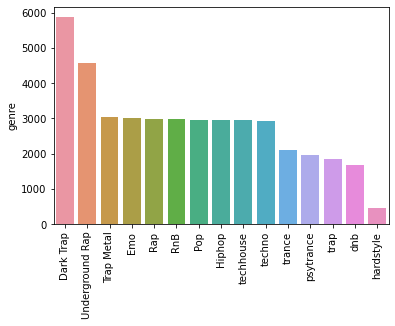

In [3]:
genres = (spotify_data['genre'].unique())
num_songs_genres = spotify_data['genre'].value_counts().sort_values(ascending=False)
sns.barplot(x=genres, y=num_songs_genres[:])
plt.xticks(rotation=90)

**Does Energy Equate to Dancability?**

I don't need to manipulate the data anymore, so lets visualize comparisons between columns. 

I graphed the scatterplot based on 3 samples, 100, 500, and 2000, to confirm that there is some negative correlation between danceability and energy. We can assume that energetic songs are not guarenteed to be dancable. 

                energy  danceability
energy        1.000000     -0.460221
danceability -0.460221      1.000000
                energy  danceability
energy        1.000000     -0.340653
danceability -0.340653      1.000000
                energy  danceability
energy        1.000000     -0.340476
danceability -0.340476      1.000000


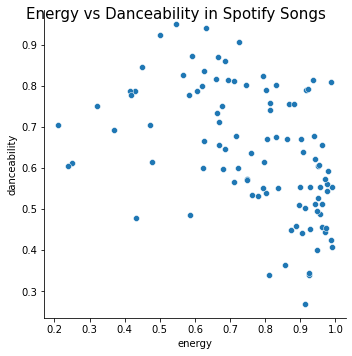

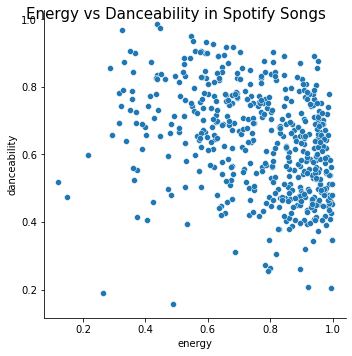

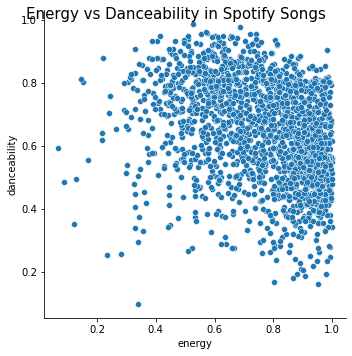

In [4]:
for x in [100, 500, 2000]:
    spotify_sample = spotify_data.sample(n=x)
    rel = sns.relplot(data=spotify_sample, x='energy', y='danceability')
    print(spotify_sample[['energy', 'danceability']].corr())
    rel.fig.suptitle('Energy vs Danceability in Spotify Songs', fontsize=15)

**What about Between the Genre and Acousticness? Or Genre and Speechiness?**

These graphs isolate the genre against one single column. This is to show visibly for humans that each genre has certain characteristics, allowing me to continue this analysis project. 

Text(0.5, 0.98, 'Song Genre Against Acousticness')

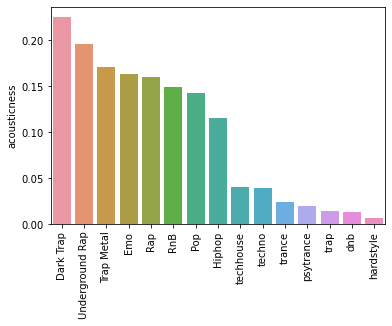

In [5]:
acoustic_avg = spotify_data.groupby('genre')['acousticness'].mean().sort_values(ascending=False)
sns.barplot(data=spotify_data, x=genres, y=acoustic_avg)
plt.xticks(rotation=90)
rel.fig.suptitle('Song Genre Against Acousticness', fontsize=15)

Text(0.5, 0.98, 'Song Genre Against Speechiness')

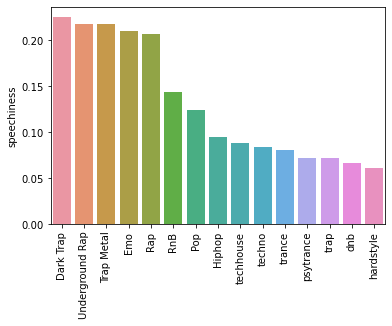

In [6]:
speechiness_avg = spotify_data.groupby('genre')['speechiness'].mean().sort_values(ascending=False)
sns.barplot(data=spotify_data, x=genres, y=speechiness_avg)
plt.xticks(rotation=90)
rel.fig.suptitle('Song Genre Against Speechiness', fontsize=15)

Interestingly, the genres are sorted in the same order. So I decided to plot acousticness against speechiness. There isn't much of a relationship though. 

Text(0.5, 0.98, 'Speechiness Against Acousticness')

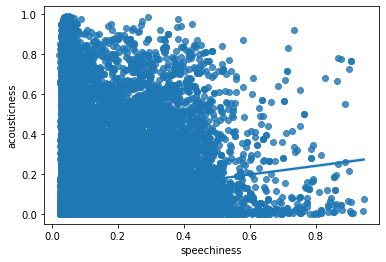

In [7]:
spotify_sample_2 = spotify_data.sample(n=2000, random_state = 7)
sns.regplot(data=spotify_data, x='speechiness', y='acousticness')
rel.fig.suptitle('Speechiness Against Acousticness', fontsize=15)

In [8]:
print(spotify_data.describe())

       danceability        energy      loudness          mode   speechiness  \
count  42305.000000  42305.000000  42305.000000  42305.000000  42305.000000   
mean       0.639364      0.762516     -6.465442      0.549462      0.136561   
std        0.156617      0.183823      2.941165      0.497553      0.126168   
min        0.065100      0.000243    -33.357000      0.000000      0.022700   
25%        0.524000      0.632000     -8.161000      0.000000      0.049100   
50%        0.646000      0.803000     -6.234000      1.000000      0.075500   
75%        0.766000      0.923000     -4.513000      1.000000      0.193000   
max        0.988000      1.000000      3.148000      1.000000      0.946000   

       acousticness  instrumentalness      liveness       valence  \
count  42305.000000      42305.000000  42305.000000  42305.000000   
mean       0.096160          0.283048      0.214079      0.357101   
std        0.170827          0.370791      0.175576      0.233200   
min        0

In [9]:
X = spotify_data.drop(['genre', 'song_name'], axis=1).values
y = spotify_data['genre'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 7)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

dt = DecisionTreeClassifier(max_depth=10)


dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))

0.5791277626758067


Clearly, our model isn't very accurate. But this might be expected when different genres have similar traits. This was especially seen when I graphed genre against acousticness. There was an evident high and low point, but it generally followed a trend that most genres had a more average acousticness level. Lets try to improve more on the model. 

In [10]:


adb_classifier = AdaBoostClassifier(base_estimator = dt, n_estimators = 50, random_state = 7)
adb_classifier.fit(X_train_scaled, y_train)
y_pred_proba = adb_classifier.predict_proba(X_test)

print(roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))

0.6135227790175285


Clearly, using boosting improved the model by a little. Lets also try Randomized Searching to simply find the most accurate hyper parameters. 

In [12]:
kf = KFold(n_splits=10, shuffle=True, random_state = 7)
param_grid  = {
    
    'criterion': ['entropy', 'gini'],
    'max_depth': np.arange(1, 20, 2),
}

dt_randomsearch = DecisionTreeClassifier()
dt_randomsearch_cv = RandomizedSearchCV(dt_randomsearch, param_grid,  n_iter = 2, cv=kf, random_state = 7)
dt_randomsearch_cv.fit(X_train_scaled, y_train)
print(dt_randomsearch_cv.best_params_, dt_randomsearch_cv.best_score_)

{'max_depth': 15, 'criterion': 'gini'} 0.5893214571307849


Interestingly, the Randomized Search was unhelpful in finding a better model. Instead, lets try using multi-label classification rather than simply multi-class. 

Clearly, the model is not very good. Therefore, I'm going to try manipulating the data based on more distinct genres. These are the top 3 and bottom 3 for speechiness and accoustic levels. 

In [10]:
edge_genres = ['Dark Trap', 'Underground Rap', 'Trap Metal',  'dnb', 'hardstyle', 'trap']
spotify_data_edge = spotify_data[spotify_data['genre'].isin(edge_genres)]
print(spotify_data_edge['genre'].unique())

X2 = spotify_data_edge.drop(['genre', 'song_name'], axis=1).values
y2 = spotify_data_edge['genre'].values

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, stratify=y2, random_state = 7)

scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.fit_transform(X2_test)

dt2 = DecisionTreeClassifier(max_depth=10)


dt2.fit(X2_train_scaled, y2_train)
y2_pred = dt2.predict(X2_test_scaled)
print(accuracy_score(y2_test, y2_pred))



['Dark Trap' 'Underground Rap' 'Trap Metal' 'trap' 'dnb' 'hardstyle']
0.7002347417840376


In [11]:
adb_classifier2 = AdaBoostClassifier(base_estimator = dt2, n_estimators = 50, random_state = 7)
adb_classifier2.fit(X2_train_scaled, y2_train)

y2_pred_proba = adb_classifier2.predict_proba(X2_test_scaled)

print(roc_auc_score(y2_test, y2_pred_proba, multi_class='ovr'))

0.9045691631212133


In [13]:


dt2_gridsearch = DecisionTreeClassifier()
dt2_gridsearch_cv = GridSearchCV(dt2_gridsearch, param_grid, cv=kf)
dt2_gridsearch_cv.fit(X2_train_scaled, y2_train)
print(dt2_gridsearch_cv.best_params_, dt2_gridsearch_cv.best_score_)


{'criterion': 'gini', 'max_depth': 9} 0.7100019573302015


**Conclusion**

With the full dataset, the highest ROC AUC Score I achieved was ~0.613, and the highest Accuracy was 0.589. In the smaller dataset, the highest ROC AUC Score was 0.905, and the highest accuracy was 0.710.

The second ROC AUC Score is quite impressive, but overall the model has it's limitations. It is still imperfect in consistently predicting song genres, though I believe it's difficult when many overlap in qualities. The only reason the ROC AUC Score for the smaller dataset was so much higher is because I specifically chose values that deviated from the middle. 

For future modifications, I would need to train the model on specific columns to see which have to most importance to the model. I believe acousticness and speechiness likely have a far larger impact on the model than time signature. Judging by it's summary statistics, most are likely in 4/4 time. Therefore, it's likely it wouldn't vary much for different genres. 

Returning to the intro, I discussed the part about using factors humans could not recognize. Even after creating this project, I still don't know what quantifies a high energy and low energy song. I can make assumptions, a soft pop song definitely would be less energetic than any house song. However, what makes one house song more energetic than another? I believe only computers could understand and sort that question. That is why I find this model so interesting, because the computer can understand music on such a different level than us. We have an emotional response, with memories impacting our perception. Computers don't, yet can still categorize genres, more times than not, correctly. 